<h2><center>Implementation on Simulated Stock</center></h2>

## Data selection: 10 year weekly data generated from GBM and CEV process

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Firstly, we work on GBM data

Import data

In [8]:
N = 50
data_path = './data_simulated/GBM/'
GBM0 = pd.read_csv(data_path + "GBM1.csv", header=0, index_col=0, squeeze=True)
price_GBM0 = GBM0.values
rtn_GBM0 = (price_GBM0[1:]-price_GBM0[:-1])/price_GBM0[:-1]
print(len(price_GBM0))
print(len(rtn_GBM0))
X = np.zeros((N, len(rtn_GBM0)))
print(X.shape)
n_prices = len(price_GBM0)

520
519
(50, 519)


(array([122., 115.,  74.,  35.,  25.,  52.,  26.,  28.,  25.,  18.]),
 array([3.27084552, 3.9123925 , 4.55393949, 5.19548647, 5.83703346,
        6.47858044, 7.12012743, 7.76167441, 8.4032214 , 9.04476838,
        9.68631537]),
 <a list of 10 Patch objects>)

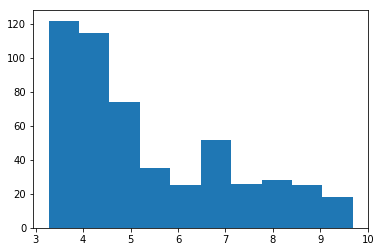

In [9]:
plt.hist(price_GBM0)

In [10]:
rtn = np.zeros((N, n_prices - 1))
price = np.zeros((N, n_prices))
i = 0
for file in os.listdir(data_path):
    if file[-3:] == "csv":
        data = pd.read_csv(data_path + file, header=0, index_col=0, squeeze=True)
        # Price
        this_price = data.values
        price[i] = this_price

        # Return
        this_rtn = (this_price[1:]-this_price[:-1])/this_price[:-1]
        #convert to annual. Seems like simple conversion is better
        this_rtn = 52 * this_rtn
        rtn[i] = this_rtn
        i += 1

Define constants

In [11]:
r = 0.025
mu = np.mean(rtn, axis=1)
print(mu)
print(rtn.shape)
cov = np.cov(rtn)
# print(cov)
print(cov.shape)
print(price[:, 0])
print(price.shape)

[ 0.03317896  0.00373742  0.03683992  0.06921542  0.18707944  0.17545104
  0.02396633  0.10777009  0.02614506  0.02574812  0.22131546  0.04498329
  0.03167616  0.05067317  0.0798175   0.10313782 -0.00468986  0.09308502
 -0.00535898  0.03795321  0.09403145 -0.03505117  0.10688326  0.10422198
  0.00436196  0.10801974  0.02710896  0.04654108  0.05462837  0.02731273
  0.03665764  0.07453948  0.06876863  0.12063271 -0.02561801  0.0436263
  0.04016938  0.12016662  0.09458565  0.08508497  0.08162248  0.14789019
  0.08903963  0.00543739  0.03947719  0.02529448 -0.01444883  0.11550556
  0.04217131  0.06954132]
(50, 519)
(50, 50)
[ 5.22276448 11.11792108 11.79051349 24.53957518 22.34988212 29.75570928
 10.71708676 22.93387588  5.66315992 24.96406736 22.72917989 27.18903692
 20.91770283 22.66012351  4.3444844  19.21765036  4.41210814  2.4228245
 28.62719145 16.06405615 26.38311276 25.57782193 29.0279219   3.51860549
 10.54130556 12.42898312 12.14873043  1.2930199  27.55688522 29.84895863
 24.5144

Recode the formula

In [12]:
def allconst(gamma = 10):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(n_prices)
    stock_hist = np.zeros(n_prices)

    for i in range(1, n_prices):
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += num_stock * (price_today - price_ytd)

        # Do as strategy
        # amount of money invested
        inverse = np.linalg.inv(np.dot(cov.T, cov))
        theta = np.dot(inverse, (mu - r) / gamma * np.exp(-r * (10 - i/52)))
        num_stock = theta / price_today
        
        
        bank_account -= (np.sum(theta) - stock_account)[0]
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

Final wealth is:  2873.837498374709


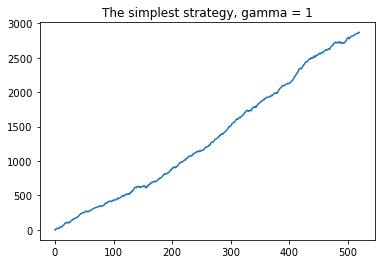

In [13]:
gamma = 1
wealth, stock_account, bank_account, stock_hist, bank_hist = allconst(gamma = gamma)
plt.title("The simplest strategy, gamma = " + str(gamma))
plt.plot(stock_hist + bank_hist)

See the CEV case

In [14]:
def CEV(gamma = 10, alpha = 1):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(n_prices)
    stock_hist = np.zeros(n_prices)

    for i in range(1, n_prices):
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += num_stock * (price_today - price_ytd)

        # Do as strategy
        # amount of money invested
        inverse1 = np.linalg.inv(cov)
        inverse2 = np.linalg.inv(np.dot(cov.T, cov))
        sharp1 = np.dot(inverse2, (mu - r) / price_today ** alpha)
        sharp2 = np.dot(inverse2, (mu - r)**2 / price_today**alpha)
        exp = np.exp(-r * (10 - i/52))
        theta =  1/gamma * sharp1 * exp  \
                - 1/gamma*(sharp2)* ((np.exp(-alpha * r * (10 - i/52)) -1 )/r) * exp
        num_stock = theta / price_today
        
        bank_account -= (np.sum(theta) - stock_account)[0]
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

In [15]:
alpha = 0.4
wealth, stock_account, bank_account, stock_hist_CEV, bank_hist_CEV = CEV(gamma = gamma, alpha = alpha)
# plt.title("Strategy assuming CEV process, gamma = " + str(gamma)+ ", alpha = " + str(alpha))
# plt.plot(stock_hist_CEV + bank_hist_CEV)

alpha_1 = -0.4
wealth_1, stock_account_1, bank_account_1, stock_hist_CEV_1, bank_hist_CEV_1 = CEV(gamma = gamma, alpha = alpha_1)
# plt.title("Strategy assuming CEV process, gamma = " + str(gamma)+ ", alpha = " + str(alpha))
# plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1)

Final wealth is:  -666.2018459611822
Final wealth is:  15819.869233353733


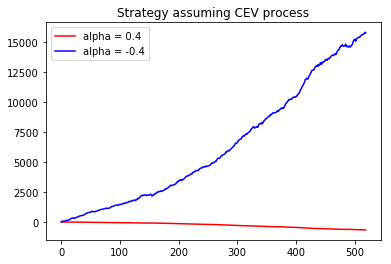

In [16]:
plt.title("Strategy assuming CEV process")
plt.plot(stock_hist_CEV + bank_hist_CEV, "r", label = "alpha = "+str(alpha))
plt.legend()
plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1, "b", label = "alpha = "+str(alpha_1))
plt.legend()
plt.show()

### Compare CEV vs Simple strategy

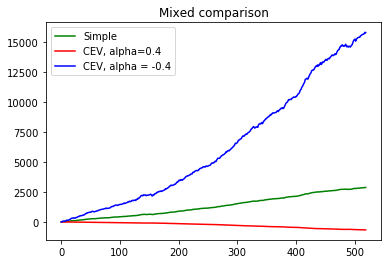

In [17]:
plt.title("Mixed comparison")
plt.plot(stock_hist + bank_hist, "g", label='Simple')
plt.legend()
plt.plot(stock_hist_CEV + bank_hist_CEV, "r", label = "CEV, alpha=" +str(alpha))
plt.legend()
plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1, "b", label = "CEV, alpha = "+str(alpha_1))
plt.legend()
plt.savefig('GBMmixed.png')
plt.show()

Theoritical ortfolio gain: -ve alpha > simple > +ve alpha

### Next, we work on simulated CEV stocks. (Note that data were generated assuming alpha = 1)

Import data

In [18]:
N = 50
data_path = './data_simulated/CEV/'
GBM0 = pd.read_csv(data_path + "CEV1.csv", header=0, index_col=0, squeeze=True)
price_GBM0 = GBM0.values
rtn_GBM0 = (price_GBM0[1:]-price_GBM0[:-1])/price_GBM0[:-1]
print(len(price_GBM0))
print(len(rtn_GBM0))
X = np.zeros((N, len(rtn_GBM0)))
print(X.shape)
n_prices = len(price_GBM0)

520
519
(50, 519)


(array([159.,  24.,  39.,  95.,  62.,  53.,  35.,  40.,   9.,   4.]),
 array([ 1.3823221 ,  2.76063867,  4.13895525,  5.51727182,  6.89558839,
         8.27390496,  9.65222153, 11.0305381 , 12.40885467, 13.78717124,
        15.16548781]),
 <a list of 10 Patch objects>)

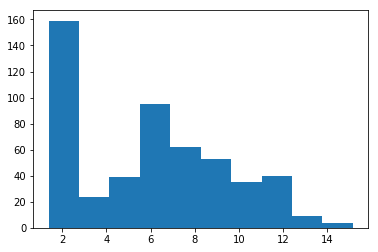

In [19]:
plt.hist(price_GBM0)

In [20]:
rtn = np.zeros((N, n_prices - 1))
price = np.zeros((N, n_prices))
i = 0
for file in os.listdir(data_path):
    if file[-3:] == "csv":
        data = pd.read_csv(data_path + file, header=0, index_col=0, squeeze=True)
        # Price
        this_price = data.values
        price[i] = this_price

        # Return
        this_rtn = (this_price[1:]-this_price[:-1])/this_price[:-1]
        #convert to annual. Seems like simple conversion is better
        this_rtn = 52 * this_rtn
    #     if len(this_rtn) != 522:
    #         print(file, ', ', len(this_rtn))
    #     else:
    #         rtn[i] = this_rtn
        rtn[i] = this_rtn
        i += 1

Define constants

In [21]:
r = 0.025
mu = np.mean(rtn, axis=1)
print(mu)
print(rtn.shape)
cov = np.cov(rtn)
# print(cov)
print(cov.shape)
print(price[:, 0])
print(price.shape)

[-0.08220338 -0.01730947  0.18852873 -0.05590641 -0.00842421  0.04487975
  0.2157111   0.00754245 -0.17133413  0.29416778  0.05711559  0.22699278
 -0.07936268  0.10419567 -0.00918686 -0.03520897 -0.07745269  0.07115933
  0.03789944  0.1419046   0.01502769 -0.04035603 -0.0580876   0.04569031
  0.04682112  0.10355521  0.03862357 -0.06735446  0.05792788  0.26663743
 -0.01064605  0.54993754 -0.06050872  0.09038369 -0.08676088  0.08554509
  0.15368409  0.03187898  0.00612428 -0.13829397  0.05785659 -0.0369295
 -0.09468409  0.03091723  0.15598406  0.08373346  0.3079247   0.04459659
 -0.15020285 -0.07746887]
(50, 519)
(50, 50)
[15.26081487 11.50005824 16.32529634 21.24321597  0.56906894  5.30586546
 18.45513049 23.7519393  16.64322629  2.46709883 17.26352064 14.17165704
 21.56891186 16.43978006 19.16220771  8.73625643 24.78070923 12.06281695
 11.34073066 24.29138079 17.32446646 17.44381712  9.78631584 13.36712277
 17.91878095 20.27091317 20.3305009  18.18934368 28.93951268  1.51161953
  1.703

Recode the formula

In [22]:
def allconst(gamma = 10):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(n_prices)
    stock_hist = np.zeros(n_prices)

    for i in range(1, n_prices):
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += num_stock * (price_today - price_ytd)

        # Do as strategy
        # amount of money invested
        inverse = np.linalg.inv(np.dot(cov.T, cov))
        theta = np.dot(inverse, (mu - r) / gamma * np.exp(-r * (10 - i/52)))
        num_stock = theta / price_today
        
        
        bank_account -= (np.sum(theta) - stock_account)[0]
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

Final wealth is:  -18.312004964044476


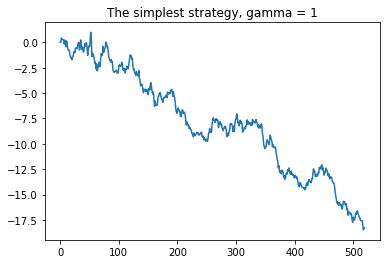

In [23]:
gamma = 1
wealth, stock_account, bank_account, stock_hist, bank_hist = allconst(gamma = gamma)
plt.title("The simplest strategy, gamma = " + str(gamma))
plt.plot(stock_hist + bank_hist)

See the CEV case

In [24]:
def CEV(gamma = 10, alpha = 1):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(n_prices)
    stock_hist = np.zeros(n_prices)

    for i in range(1, n_prices):
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += num_stock * (price_today - price_ytd)

        # Do as strategy
        # amount of money invested
        inverse1 = np.linalg.inv(cov)
        inverse2 = np.linalg.inv(np.dot(cov.T, cov))
        sharp1 = np.dot(inverse2, (mu - r) / price_today ** alpha)
        sharp2 = np.dot(inverse2, (mu - r)**2 / price_today**alpha)
        exp = np.exp(-r * (10 - i/52))
        theta =  1/gamma * sharp1 * exp  \
                - 1/gamma*(sharp2)* ((np.exp(-alpha * r * (10 - i/52)) -1 )/r) * exp
        num_stock = theta / price_today
        
        bank_account -= (np.sum(theta) - stock_account)[0]
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

In [25]:
alpha = 1
wealth, stock_account, bank_account, stock_hist_CEV, bank_hist_CEV = CEV(gamma = gamma, alpha = alpha)
# plt.title("Strategy assuming CEV process, gamma = " + str(gamma)+ ", alpha = " + str(alpha))
# plt.plot(stock_hist_CEV + bank_hist_CEV)

alpha_1 = -1
wealth_1, stock_account_1, bank_account_1, stock_hist_CEV_1, bank_hist_CEV_1 = CEV(gamma = gamma, alpha = alpha_1)
# plt.title("Strategy assuming CEV process, gamma = " + str(gamma)+ ", alpha = " + str(alpha))
# plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1)

Final wealth is:  6.001475195112889
Final wealth is:  -667.0694079436103


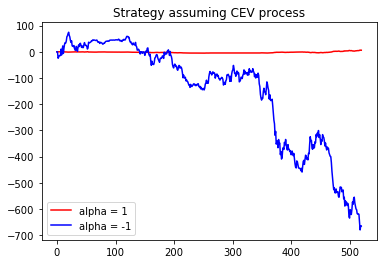

In [26]:
plt.title("Strategy assuming CEV process")
plt.plot(stock_hist_CEV + bank_hist_CEV, "r", label = "alpha = "+str(alpha))
plt.legend()
plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1, "b", label = "alpha = "+str(alpha_1))
plt.legend()
plt.savefig('CEV1vs-1.png')
plt.show()

### Compare CEV vs Simple strategy

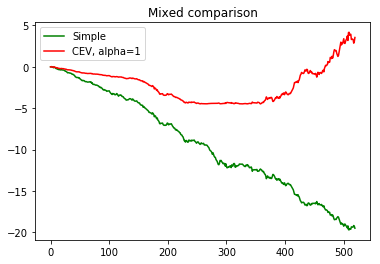

In [67]:
plt.title("Mixed comparison")
plt.plot(stock_hist + bank_hist, "g", label='Simple')
plt.legend()
plt.plot(stock_hist_CEV + bank_hist_CEV, "r", label = "CEV, alpha=" +str(alpha))
plt.legend()
# plt.plot(stock_hist_CEV_1 + bank_hist_CEV_1, "b", label = "CEV, alpha = "+str(alpha_1))
# plt.legend()
plt.savefig('CEV1vssimp.png')
plt.show()